# Image preprocessing using SageMaker

In [25]:
!pip install opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 25.4 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import sagemaker, boto3, json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()
s3 = boto3.resource('s3', region_name=aws_region)
bucket = s3.Bucket('isicbucket')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
import pandas as pd

metadata = pd.read_csv("ISICmerge2019_2020_remove_dup_img.csv")
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57729 entries, 0 to 57728
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_id                       57729 non-null  object 
 1   patient_id                     55650 non-null  object 
 2   target                         57729 non-null  object 
 3   source                         57729 non-null  object 
 4   sex                            57310 non-null  object 
 5   age_approx                     57254 non-null  float64
 6   benign_malignant               57729 non-null  object 
 7   anatom_site_general_challenge  54597 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.5+ MB


In [6]:
classes = metadata.target.unique()
classes

array(['unknown', 'nevus', 'melanoma', 'keratosis', 'dermatofibroma',
       'squamous cell carcinoma', 'basal cell carcinoma', 'vascular skin',
       'actinic keratoses'], dtype=object)

### Functions to Read and Write images to s3 without downloading locally

In [7]:
from PIL import Image
from io import BytesIO
import numpy as np

def read_image_from_s3(key, bucket=bucket):
    """Load image file from s3.

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    np array
        Image array
    """
    
    object = bucket.Object(key)
    response = object.get()
    file_stream = response['Body']
    im = Image.open(file_stream)
    return np.array(im)

def write_image_to_s3(img_array, key, bucket=bucket):
    """Write an image array into S3 bucket

    Parameters
    ----------
    bucket: string
        Bucket name
    key : string
        Path in s3

    Returns
    -------
    None
    """
    
    object = bucket.Object(key)
    file_stream = BytesIO()
    im = Image.fromarray(img_array)
    im.save(file_stream, format='jpeg')
    object.put(Body=file_stream.getvalue())

### Test read_image_from_s3

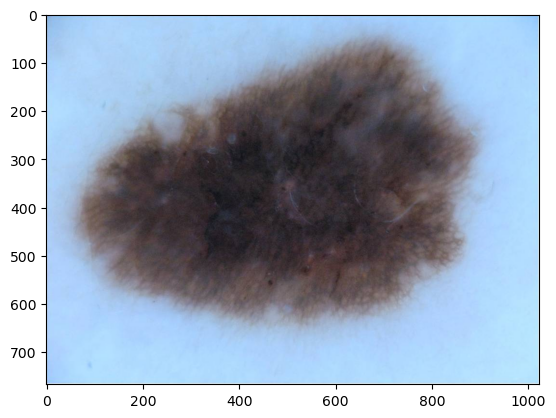

In [9]:
import matplotlib.pyplot as plt

image = read_image_from_s3("ISIC_Raw_Images/ISIC_0000000.jpg")
plt.imshow(image)

### Preprocess and create filestructure

In [41]:
import cv2
import matplotlib.pyplot as plt

#train_val_test_split = (70, 20, 10)

for target in classes:
    # get a list of filenames in that target
    image_filenames = metadata[metadata.target == target].image_id[:2]

    for image_fn in image_filenames:
        # read image in
        image = read_image_from_s3("ISIC_Raw_Images/"+image_fn)
        
        # square center crop
        height, width = image.shape[:-1]
        if width > height:
            image = image[:, (width-height)//2:(width+height)//2, :]
        elif width < height:
            image = image[(height-width)//2:(height+width)//2, :, :]
        
        # resize (224x224)
        image = cv2.resize(image, dsize=(224, 224))
        
        #plt.imshow(image)
        
        # Save to S3://isicbucket/preprocessed/train-val-test/target/image_fn
        write_image_to_s3(image, f"preprocessed/example/{target}/{image_fn}")
        
        